<a href="https://colab.research.google.com/github/drpeppurr/yamcha/blob/main/tutorial/YAMCHA_tutorial_ch9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Load packages etc...

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from matplotlib import cm, ticker

from scipy.integrate import solve_ivp,cumulative_trapezoid

# Note: might need to set this high if running very big mechanisms, like the full MCM..
#       3000 seems to be sufficient for full MCM.
# import sys
# sys.setrecursionlimit(3000)

In [2]:
# ========================================================================================
# The prognostic equation of the 1D diffusion problem is:
#     dc/dt = K*d2c/dz2
# where K is the diffusivity (for now assume it's constant), z is the height,
# and c is the tracer concentration as a function of time (t) and z.
# We'll solve this using finite difference method, in a uniform z grid with spacing dz.
#     c[i] = f[zi]
# Talor serios at zi, or the i th layer, is:
#     f(zi+dz) = f(zi) + sum( dz^j/j! * f^(j) )
# where f^(j) is the j-order derivative, f^(1) is just f', f^(2) is f'', etc..
# To estimate the 2nd order derivative, run the first few terms of the Talor expansion:
#     f[i+1] = f[zi+dz] = f[zi] + dz*f'[zi] + dz^2/2!*f'' + dz^3/3!*f''' + O(dz^4)
#     f[i-1] = f[zi-dz] = f[zi] - dz*f'[zi] + dz^2/2!*f'' - dz^3/3!*f''' + O(dz^4)
# Add these together:
#     f[i+1] + f[i-1] = 2*f[i] + dz^2*f''
#     f'' = (f[i+1] -2*f[i] + f[i-1])/dz/dz
# Plut it back to the prognostic equation:
#     d2c/dz2 = (c[i+1] - 2*c[i] + c[i-1])/dz/dz
# where c[i] is the concentration of the tracer at layer i, and dz is the layer thickness
#     dc[i]/dt = K/dz/dz*((c[i-1]-c[i]) - (c[i]-c[i+1]))
#     dc[i]/dt = K/dz/dz*(c[i-1] - 2*c[i] + c[i+1])
# This is what we can use in our numerical scheme.
# ----------------------------------------------------------------------------------------
# But we assumed K is constant. If K is also a function of z, let's call it Kz...
# Rearrange this we got this:
#     dc/dt = (d/dz)*(Kz*dc/dz)
# This term Kz*dc/dz is actually the flux of the tracer, F, which is normally solved at the
# layer interface rather than layer center, so it's easier to make sure mass is conserved.
#     dc[i]/dt = dF/dz = (F[i] - F[i+1])/dz
#     dc[i]/dt = (Kz[i]*(c[i-1]-c[i]) - Kz[i+1]*(c[i]-c[i+1]))/dz
# where F[i] is the flux across the lower interface of i th layer, F[i+1] is the flux
# accross the upper interface of i th layer, which is also the flux across the lower
# interface of the i+1 th layer.
# ----------------------------------------------------------------------------------------
# We also need to take care of the boundary condition, i.e. what happens in the bottom-most
# and top-most layers.
# =========================================================================================

2. Solve it as an ODE!

<ipython-input-3-e3053a23f0af>:48: RuntimeWarning: invalid value encountered in power
  kz_m2_s = 0.4*ustar*z_interface_m*((1.-z_interface_m/pblh_m)**1.5)/(1.+4.7*z_interface_m/L_Obukhov)


32 32 31


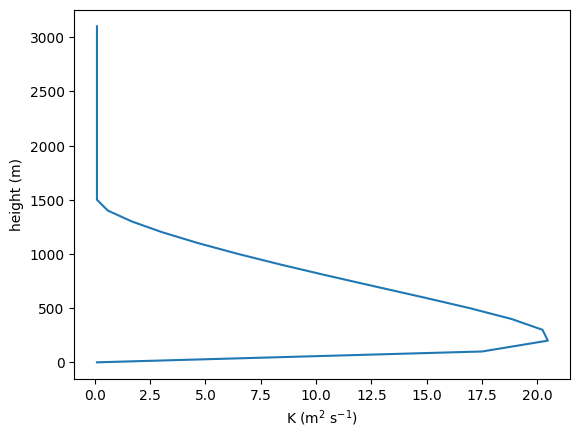

done this in: 12.95984172821045 seconds


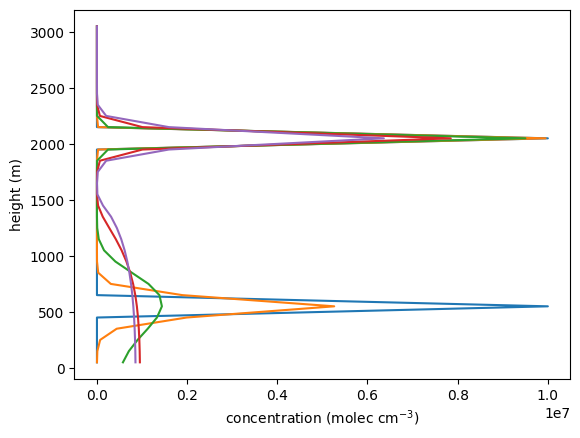

20000000.0
19999999.99999999
19999999.999999978


In [3]:
def dcodt_vertical_diffusion(t,conc):
    dcodt_out = np.zeros(len(z_m))
    for i in range(0,nz):
        if i==0:         # bottom of the model
            dcodt_out[i] = (1./dz_m/dz_m)*(-kz_m2_s[i+1]*(conc[i]-conc[i+1]))
        elif i==-1+nz:   # top of the model
            dcodt_out[i] = (1./dz_m/dz_m)*(kz_m2_s[i]*(conc[i-1]-conc[i]))
        else:            # all other layers
            dcodt_out[i] = (1./dz_m/dz_m)*(kz_m2_s[i]*(conc[i-1]-conc[i])-kz_m2_s[i+1]*(conc[i]-conc[i+1]))
    return dcodt_out


# --- height grid: layer center
dz_m = 100
z_m = np.arange(dz_m/2, 3000.+dz_m, dz_m)
nz = len(z_m)

# --- height grid: layer interface
z_interface_m = np.zeros(len(z_m)+1)
for i in range(len(z_interface_m)):
    if i==0: z_interface_m[i] = 0
    else: z_interface_m[i] = 2.*(z_m[i-1]-z_interface_m[i-1])+z_interface_m[i-1]

pblh_m = 1500.           # depth of boundary layer
T_surf = 298.            # surface temperatre
uref = 3.                # windspeed at the reference height
zref = 2.                # reference height
z0 = 0.5                 # roughness
d_displacement = 0.8*z0  # displacement height
Qvt_surf_K_m_s = 0.2     # virtual temperature flux at surface

# --- integrated from of stability correction function for momentum
#     Stull book, Chapter 9. Eq. 9.7.5h and 9.7.5i
def PSI(in_zeta):
    if in_zeta>=0:  # stable
        out = 4.7*in_zeta
    else:           # unstable
        x = (1.-15.*in_zeta)**0.25
        out = -2.*np.log(0.5*(1+x))-np.log(0.5*(1+x*x))+2.*np.arctan(x)-np.pi/2.
    return out

zeta = 0
ustar = 0.4*uref/np.log((zref-d_displacement)/z0-PSI(zeta))  # friction velocity
L_Obukhov = (ustar**3.)*T_surf/0.4/9.8/Qvt_surf_K_m_s        # Obukhov length
kz_min_m2_s = 0.1                                            # Eddy diffusivity: min value

# --- now calculate the Eddy diffusivity profile. At the layer interfaces!
kz_m2_s = 0.4*ustar*z_interface_m*((1.-z_interface_m/pblh_m)**1.5)/(1.+4.7*z_interface_m/L_Obukhov)
kz_m2_s = np.where(np.isnan(kz_m2_s),kz_min_m2_s,kz_m2_s)
kz_m2_s = np.where(kz_m2_s>=kz_min_m2_s, kz_m2_s, kz_min_m2_s)

print(len(kz_m2_s), len(z_interface_m), len(z_m))

plt.plot(kz_m2_s, z_interface_m)
plt.xlabel(r'K (m$^2$ s$^{-1}$)')
plt.ylabel('height (m)')
# plt.xscale('log')
plt.show()


# ===================
# Model configuration
# ===================
# --- time stamps
total_run_time_days = 0.3         # how long you want to run the model?
output_frequency_seconds = 10           # how often do you save the output?
tout_s = np.arange(0,total_run_time_days*86400,output_frequency_seconds)  # output time stamps, unit: second
conc = np.zeros((len(tout_s),len(z_m)))                 # this stores the concentrations. unit: molec/cm3

# --- initial condition
conc[0,20] =1e+7
conc[0,5] =1e+7


start_time = time.time()
for i,t in enumerate(tout_s):
    if i!=0: conc[i,:] = solve_ivp(dcodt_vertical_diffusion,tout_s[0:2],conc[i-1,:],t_eval=[output_frequency_seconds],
                                   method='BDF', rtol=1e-5,atol=1e-5).y[:,0]
print( 'done this in: %s seconds' % (time.time() - start_time))



plt.plot(conc[0,:], z_m)
plt.plot(conc[int(0.01*len(tout_s)),:], z_m)
plt.plot(conc[int(0.1*len(tout_s)),:], z_m)
plt.plot(conc[int(0.5*len(tout_s)),:], z_m)
plt.plot(conc[-1,:], z_m)
plt.xlabel(r'concentration (molec cm$^{-3}$)')
plt.ylabel('height (m)')
plt.show()

print(np.sum(conc[0,:]))
print(np.sum(conc[int(0.5*len(tout_s)),:]))
# print(np.sum(conc[1000,:]))
print(np.sum(conc[-1,:]))

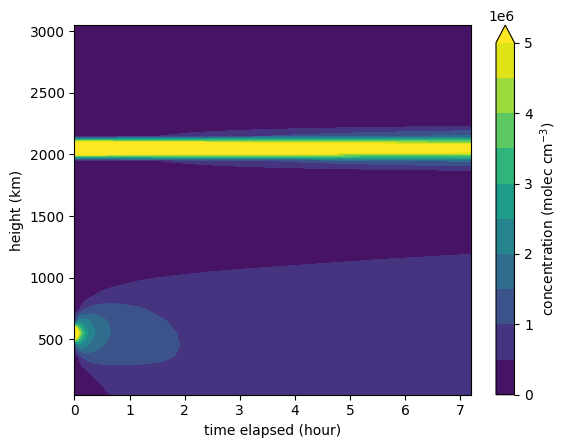

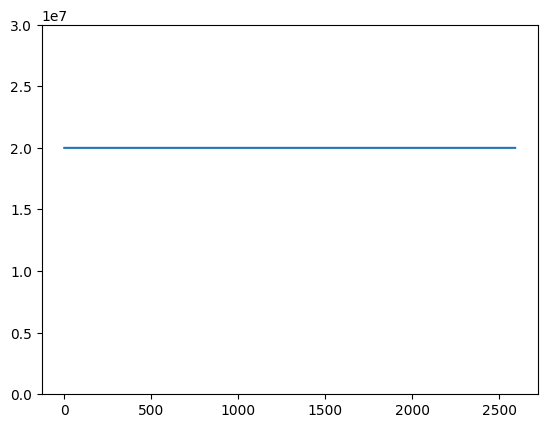

In [4]:
plt.contourf(tout_s/3600., z_m, conc.T, np.linspace(0,0.5*np.nanmax(conc[0,:]),11), extend='max')
plt.colorbar().set_label(r'concentration (molec cm$^{-3}$)')
plt.xlabel('time elapsed (hour)')
plt.ylabel('height (km)')
plt.show()

plt.plot(np.sum(conc,axis=1))
plt.ylim([0,1.5*np.sum(conc[0,:])])
plt.show()

3. Solve the diffusion equation using explicit scheme...

32 32 31


<ipython-input-14-44791a6ed6bc>:35: RuntimeWarning: invalid value encountered in power
  kz_m2_s = 0.4*ustar*z_interface_m*((1.-z_interface_m/pblh_m)**1.5)/(1.+4.7*z_interface_m/L_Obukhov)


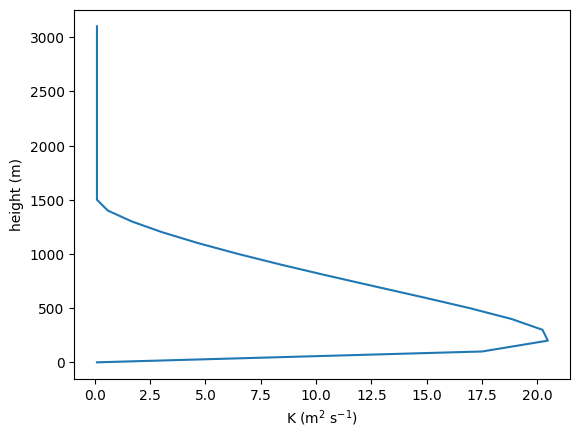

dz = 100 m
dt = 10.000 s
done this in: 0.16936731338500977 seconds


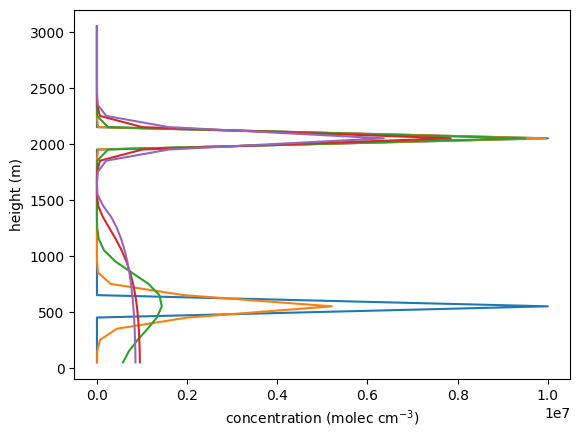

20000000.0
19999999.999999996
20000000.0


In [14]:

# --- height grid: layer center
dz_m = 100
z_m = np.arange(dz_m/2, 3000.+dz_m, dz_m)
nz = len(z_m)

# --- height grid: layer interface
z_interface_m = np.zeros(len(z_m)+1)
for i in range(len(z_interface_m)):
    if i==0: z_interface_m[i] = 0
    else: z_interface_m[i] = 2.*(z_m[i-1]-z_interface_m[i-1])+z_interface_m[i-1]

pblh_m = 1500.           # depth of boundary layer
T_surf = 298.            # surface temperatre
uref = 3.                # windspeed at the reference height
zref = 2.                # reference height
z0 = 0.5                 # roughness
d_displacement = 0.8*z0  # displacement height
Qvt_surf_K_m_s = 0.2     # virtual temperature flux at surface


# --- integrated from of stability correction function for momentum
#     Stull book, Chapter 9. Eq. 9.7.5h and 9.7.5i
def PSI(in_zeta):
    if in_zeta>=0:  # stable
        out = 4.7*in_zeta
    else:           # unstable
        x = (1.-15.*in_zeta)**0.25
        out = -2.*np.log(0.5*(1+x))-np.log(0.5*(1+x*x))+2.*np.arctan(x)-np.pi/2.
    return out

zeta = 0  # neutral
ustar = 0.4*uref/np.log((zref-d_displacement)/z0-PSI(zeta))
L_Obukhov = (ustar**3.)*T_surf/0.4/9.8/Qvt_surf_K_m_s
kz_min_m2_s = 0.1
kz_m2_s = 0.4*ustar*z_interface_m*((1.-z_interface_m/pblh_m)**1.5)/(1.+4.7*z_interface_m/L_Obukhov)
kz_m2_s = np.where(np.isnan(kz_m2_s),kz_min_m2_s,kz_m2_s)
kz_m2_s = np.where(kz_m2_s>=kz_min_m2_s, kz_m2_s, kz_min_m2_s)

print(len(kz_m2_s), len(z_interface_m), len(z_m))


plt.plot(kz_m2_s, z_interface_m)
plt.xlabel(r'K (m$^2$ s$^{-1}$)')
plt.ylabel('height (m)')
# plt.xscale('log')
plt.show()



dt = 10
total_run_time_days = 0.3
tout_s = np.arange(0, 86400*total_run_time_days, dt)
n_tstep = len(tout_s)
print('dz = %.0d m' % (dz_m))
print('dt = %.3f s' % (dt))

conc = np.zeros((n_tstep,nz))

# --- initial condition
# conc[0,0] = 1e+7
conc[0,20] =1e+7
conc[0,5] =1e+7

# --- set up emission
emis_flux_molec_cm2_s = np.ones(len(tout_s)) * 1e+7

start_time = time.time()
for n in range(1,n_tstep):
    for i in range(0,nz):
        if i==0:         # bottom of the model
            conc[n,i] = conc[n-1,i] + dt/dz_m/dz_m*(-kz_m2_s[i+1]*(conc[n-1,i]-conc[n-1,i+1]))
                         # add emissions at the bottom!
            # conc[n,i] = conc[n,i] + emis_flux_molec_cm2_s[i]/(dz_m*100.)*dt
        elif i==-1+nz:   # top of the model
            conc[n,i] = conc[n-1,i] + dt/dz_m/dz_m*(kz_m2_s[i]*(conc[n-1,i-1]-conc[n-1,i]))
        else:            # all other layers
            conc[n,i] = conc[n-1,i] + dt/dz_m/dz_m*(kz_m2_s[i]*(conc[n-1,i-1]-conc[n-1,i])-kz_m2_s[i+1]*(conc[n-1,i]-conc[n-1,i+1]))
print( 'done this in: %s seconds' % (time.time() - start_time))



plt.plot(conc[0,:], z_m)
plt.plot(conc[int(0.01*len(tout_s)),:], z_m)
plt.plot(conc[int(0.1*len(tout_s)),:], z_m)
plt.plot(conc[int(0.5*len(tout_s)),:], z_m)
plt.plot(conc[-1,:], z_m)
plt.xlabel(r'concentration (molec cm$^{-3}$)')
plt.ylabel('height (m)')
plt.show()

print(np.sum(conc[0,:]))
print(np.sum(conc[int(0.5*n_tstep),:]))
# print(np.sum(conc[1000,:]))
print(np.sum(conc[-1,:]))

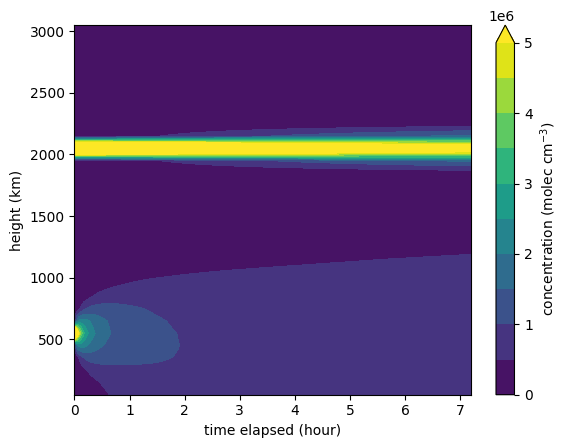

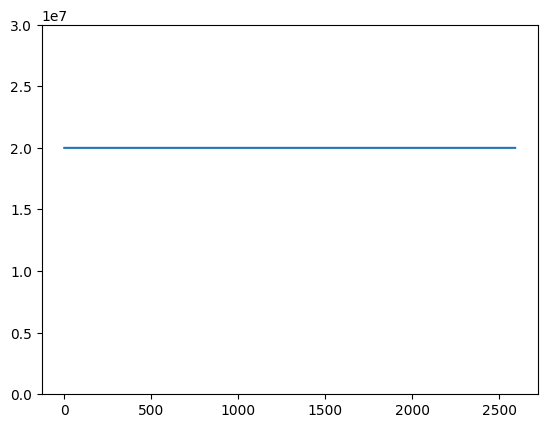

In [15]:
plt.contourf(tout_s/3600., z_m, conc.T, np.linspace(0,0.5*np.nanmax(conc[0,:]),11), extend='max')
plt.colorbar().set_label(r'concentration (molec cm$^{-3}$)')
plt.xlabel('time elapsed (hour)')
plt.ylabel('height (km)')
plt.show()

plt.plot(np.sum(conc,axis=1))
plt.ylim([0,1.5*np.sum(conc[0,:])])
plt.show()